<h1><center>Waste Management Modelling</center></h1>

### Load Inpendencies

In [8]:
import sys
import tensorflow.keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly
import sklearn as sk
import tensorflow as tf

### Load Data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen_train = ImageDataGenerator(rescale = 1/255, shear_range = 0.2, zoom_range = 0.2, 
                               brightness_range = (0.1, 0.5), horizontal_flip=True)
train_data = gen_train.flow_from_directory("recycling_waste_dataset",
                                           target_size = (224, 224), batch_size = 32, class_mode="categorical")

Found 8369 images belonging to 9 classes.


In [38]:
print(gen_train)

In [41]:
print(train_data)

### Train Model

In [10]:
# let's create a model
# here i'm going to use VGG16 model's parameter to solve this problem
from tensorflow.keras.applications.vgg16 import VGG16
# here i'm going to take input shape, weights and bias from imagenet and include top False means
# i want to add input, flatten and output layer by my self
vgg16 = VGG16(input_shape = (224, 224, 3), weights = "imagenet", include_top = False)

2021-11-12 12:33:55.650879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58892288/58889256 [==============================] - 12s 0us/step


In [12]:
# now vgg16 weights are already train so i don't want to train that weights again
# so let's make trainable = False
for layer in vgg16.layers:
    layer.trainable = False

In [13]:
# let's add flatten layer or let's connect VGG16 with our own flatten layer
from tensorflow.keras import layers
x = layers.Flatten()(vgg16.output)

In [14]:
# now let's add output layers or prediction layer
prediction = layers.Dense(units = 9, activation="softmax")(x)
# creating a model object
model = tf.keras.models.Model(inputs = vgg16.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
# now let's compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics =["accuracy"])
result = model.fit_generator(train_data, epochs = 5, steps_per_epoch=len(train_data))

Epoch 1/5
262/262 [==============================] - 1134s 4s/step - loss: 1.6495 - accuracy: 0.4376
Epoch 2/5
262/262 [==============================] - 1692s 6s/step - loss: 1.4568 - accuracy: 0.5038
Epoch 3/5
262/262 [==============================] - 1171s 4s/step - loss: 1.3662 - accuracy: 0.5260
Epoch 4/5
262/262 [==============================] - 1180s 5s/step - loss: 1.3484 - accuracy: 0.5468
Epoch 5/5
262/262 [==============================] - 1183s 5s/step - loss: 1.2891 - accuracy: 0.5625


### Model Evaluation

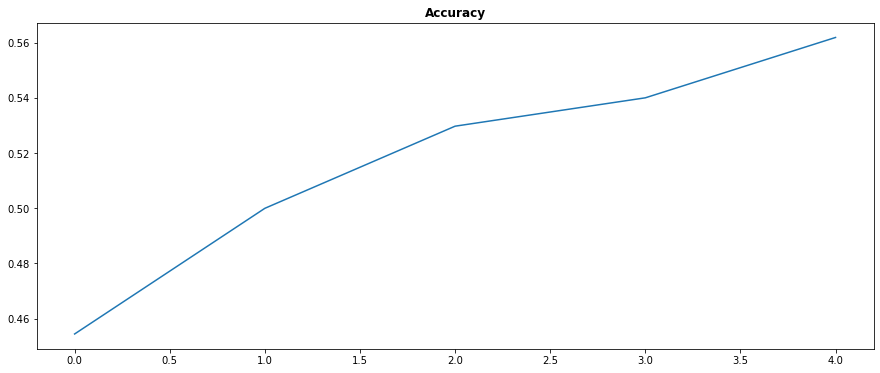

In [39]:
plt.figure(figsize=(15,6))
plt.title("Accuracy", fontweight='bold')
plt.plot(result.history["accuracy"])
plt.show()

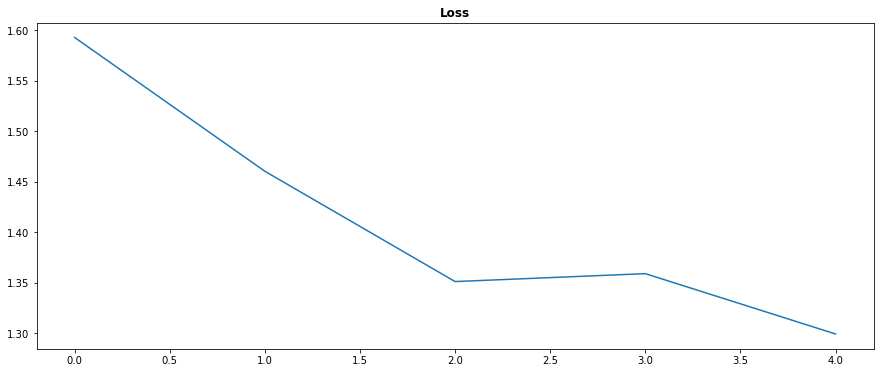

In [40]:
plt.figure(figsize=(15,6))
plt.title("Loss", fontweight='bold')
plt.plot(result.history["loss"])
plt.show()

### Testing & Deployment

In [19]:
from tensorflow.keras.preprocessing import image
output_class = ["batteries", "clothes", "e-waste", "glass", "light blubs", "metal", "organic", "paper", "plastic"]

def waste_prediction(new_image):
    test_image = image.load_img(new_image, target_size = (224,224))
    plt.axis("off")
    plt.imshow(test_image)
    plt.show()
    
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    predicted_array = model.predict(test_image)
    predicted_value = output_class[np.argmax(predicted_array)]
    predicted_accuracy = round(np.max(predicted_array) * 100, 2)

    print("Your waste material is ", predicted_value, " with ", predicted_accuracy, " % accuracy")

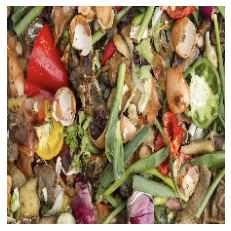

Your waste material is  organic  with  100.0  % accuracy


In [30]:
#let's make the prediction
waste_prediction("test_images/organic.png")

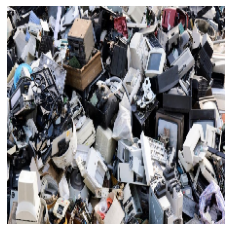

Your waste material is  e-waste  with  99.99  % accuracy


In [31]:
#let's make the prediction
waste_prediction("test_images/e_waste.png")

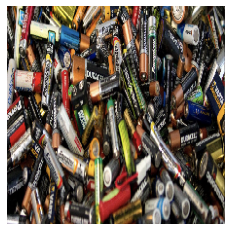

Your waste material is  e-waste  with  96.39  % accuracy


In [32]:
#let's make the prediction
waste_prediction("test_images/batteries.png")

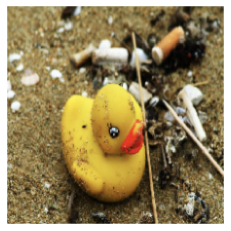

Your waste material is  plastic  with  80.25  % accuracy


In [33]:
#let's make the prediction
waste_prediction("test_images/duck.png")

In [34]:
#save the model
#deploy the model
model.save("waste_classifier_model.h5")